<h1>Creating OSM Completeness Model</h1>

<p>This Jupyter notebook takes as input training polygons produced from the <a href="https://observablehq.com/d/3e055fdf7a60f712">Mapbox OSM Training Set Creation</a> Observable notebook. To use this notebook, you'll also need to sign up for a <a href="https://earthengine.google.com/new_signup/"> Google Earth Engine Account</a>.</p>

### deviations from initial notebook:
- Afghanistan landcover @ 10m resolution, modified zonal stats code instead of bilinear interpolation. 
- modified zonal stats code includes method to ingest multiclass raster
- more regression/correlation processing at the end. 


In [33]:
import seaborn as sns
import geojson
import json
## in windows, there may be an issue importing geopandas. follow nlt completeness readme from github to change rtree's core.py
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, box, mapping, Point, Polygon
import numpy as np
import osmnx as ox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import math
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils, point_query
import gdal, gdalconst

In [34]:
# authenticate account using google.
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/3wFqZatmqRVKfCGKOwbTtz4kTxmCoSpf65RFeLCYKJcvPcRjZFb4FgA

Successfully saved authorization token.


### create a class for geoJson feature collections

In [35]:
# class for GeoJSON feature collections. To complete analysis need two:
#1. training data from Observable notebook
#2. grid data that wil be run through trained model and output
class Features:
    
    def __init__(self, filename=''):
        self.filename = filename
        self.polygons = []
        
        if filename=='':
            return
        
        with open(filename) as f:
            self.data = json.load(f)
        try:
            self.features = self.data['features']
        except:
            print("JSON file did not have features array")
            
    def getPolygons(self):
        for feature in self.features:
            g = shape(feature['geometry']).buffer(0)
            self.polygons.append(g)
        print(len(self.polygons))
        return self.polygons
    
    #used if creating own grid, not reading JSON file in __init__
    def setData(self, df):
        self.data = mapping(df.geometry)
        #don't need bbox for anything so delete it to reduce output file size
        del self.data['bbox']
        for feature in self.data['features']:
            del feature['bbox']
        self.features = self.data['features']
    
    def projectGeoDataFrame(self, *args):
        if len(args) > 0:
            df = args[0]
        else:
            df = self.geoDataFrame
        
        avg_longitude = (self.bounds[0] + self.bounds[2])/2
        utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
        utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
   
        # project the GeoDataFrame to the UTM CRS
        self.geoDataFrameProjected = df.to_crs(utm_crs)
        
        return self.geoDataFrameProjected
    
    def createGeoDataFrame(self):
        self.geoDataFrame = gpd.GeoDataFrame({
            'geometry': self.polygons
        })
        self.geoDataFrame.crs = "EPSG:4326"
        return self.geoDataFrame
        
    def getBounds(self):
        self.bounds = self.geoDataFrame.total_bounds
        return self.bounds
    
    def getClippingBox(self):
        if not hasattr(self, 'bounds'):
            self.getBounds()
        bbox = box(self.bounds[0], self.bounds[1], self.bounds[2], self.bounds[3])
        self.bbox = bbox
        self.clippingBox = {'type': 'Feature', 'properties': {}, 'geometry': mapping(bbox)}
        return self.clippingBox

### create a class to work with rasters

In [36]:
#class to work with tiff datasets
class Raster:
    
    def __init__(self, filename):
        self.filename = filename
    def returnBounds(self,band):
        with rasterio.open(self.filename) as src:
            return src.bounds
    def dataFromBounds(self, band, bounds):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            window = rasterio.windows.from_bounds(bounds[0],bounds[1],bounds[2],bounds[3], src.transform)
            self.boundsData = src.read(band, window=window)
            self.boundsTransform = src.window_transform(window)
    def dataFromShape(self,band,shape):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            self.maskData, self.maskTransform = rasterio.mask.mask(src, [shape], crop=True, nodata=0)
            self.maskData = self.maskData[band-1, :, :]

### function to collect global forest change imagery

In [37]:
def eeForest(features):
    ee.Initialize()
    gfcImage = ee.Image("UMD/hansen/global_forest_change_2018_v1_6")
    FCL0018 = gfcImage.select(['loss']).eq(1).rename('fcloss0018')
    FC00 = gfcImage.select(['treecover2000']).gte(20)
    FC18 = FC00.subtract(FCL0018).rename('FC18')
    FC18Area = FC18.multiply(ee.Image.pixelArea()).rename('FC18Area')
    forestSum = FC18Area.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return forestSum.getInfo()

### functions for creating masks (?) and calculating texture.

In [38]:
def maskEdge(img):
    mask = img.select(0).unitScale(-25, 5).multiply(255).toByte().connectedComponents(ee.Kernel.rectangle(1,1), 100);
    return img.updateMask(mask.select(0))

def eeTexture(features, JSONob):
    ee.Initialize()
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(JSONob.clippingBox['geometry']).filterMetadata('instrumentMode', 'equals', 'IW')
    .select(['VV', 'angle']))

    se1 = s1.select(0).filterDate('2020-01-01', '2020-07-31').median()

    textureMean = se1.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 10
        #maxPixels= 1e9
    )
    return textureMean.getInfo()

### function to calculate slope from STRM

In [39]:
## TRY INGESTING 10M STRM
def eeSlope(features):
    ee.Initialize()
    srtm = ee.Image("CSP/ERGo/1_0/Global/SRTM_mTPI")
    slope = ee.Terrain.slope(srtm).rename('slope')
    slopeMean = slope.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 270
        #maxPixels= 1e9
    )
    return slopeMean.getInfo()

### function to calculate NTL statistics

In [40]:
#only return 2020 
def eeVIIRSNTL(features):
    ee.Initialize()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

    #2019 viirs
    viirs_2020_mean = viirs.select('avg_rad').filterDate('2020-01-01','2020-07-01').mean().rename('viirs_2020_mean')
    viirs_2020_median = viirs.select('avg_rad').filterDate('2020-01-01','2020-07-01').median().rename('viirs_2020_median')
    viirs_2020_max = viirs.select('avg_rad').filterDate('2020-01-01','2020-07-01').max().rename('viirs_2020_max')

    VIIRS2020 = viirs_2020_mean.addBands(viirs_2020_median).addBands(viirs_2020_max)

    stats2020 = VIIRS2020.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return stats2020.getInfo()

### function to mask clouds in imagery & calculate NDVI

In [41]:
def maskS2clouds(image):
    qa = image.select('QA60')

    #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    #Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
            qa.bitwiseAnd(cirrusBitMask).eq(0)))

    #Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask) #.divide(10000)
      .select("B.*")
      .copyProperties(image, ["system:time_start"]))

def eeIndices(features, JSONob):
   
    ee.Initialize()
    #Map the function over one year of data and take the median.
    #Load Sentinel-2 TOA reflectance data.
    collection = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2020-01-01', '2020-07-31')
        #Pre-filter to get less cloudy granules.
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(maskS2clouds))

    composite = collection.median().clip(ee.Feature(JSONob.clippingBox))#.int()  
    # normalized built index
    ndbi = composite.normalizedDifference(['B11','B8']).rename('ndbi')
    # normalized vegetation index
    ndvi = composite.normalizedDifference(['B8','B4']).rename('ndvi')
    # soil adjusted vegetation index
    savi = composite.expression(
        '1.5 * (NIR-RED) / (NIR+RED+0.5)', {
          'NIR': composite.select('B8'),
          'RED': composite.select('B4')
    }).rename('savi').float()
    # urban index - not sure how this is different from NDBI
    urbanIndex = composite.normalizedDifference(['B12','B8']).rename('ui')
    sen2AllIndices = ndvi.addBands(ndbi).addBands(savi).addBands(urbanIndex)
    #Calculate Indices
    finalIndices = sen2AllIndices.reduceRegions(
    collection= ee.FeatureCollection(features),
    reducer= ee.Reducer.sum(),
    scale= 10,
    )
    return finalIndices.getInfo()

## updated code
### Add 10 meter FAO Global Landcover Data
### expected result: more accurate model 

<p>Download <a href ="https://data.humdata.org/search?organization=facebook&q=high%20resolution%20population&ext_page_size=25&sort=score%20desc%2C%20if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc">Facebook population data</a> and/or <a href="https://www.worldpop.org/geodata/listing?id=29">WorldPop</a> data for your area of interest and insert the paths into the cell below.</p>

In [ ]:
landcoverRaster = rasterio.open(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass1.tif")
print(landcoverRaster.crs)

In [ ]:
input_raster = gdal.Open(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass2.tif")
outname = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass2_proj.tif"
gdal.Warp(outname, input_raster, dstSRS="EPSG:4326")

### Ingest global urban footprint, population & landcover
#### test new zonal stats with dict method from Corey & Robert

In [42]:
###############################################
# processing training data JSON
###############################################

#change this file path to the location of the json data downloaded from the OSM Training Set Observable notebook
trainingJSON = Features(r"C:\Users\wb557957\Desktop\OSM_Completeness\WB_OSM_AFG\outputCellsJSONAfg575.json")

#order these 6 lines are called is important
trainingPolys = trainingJSON.getPolygons()
trainingDF = trainingJSON.createGeoDataFrame()
trainingFeatures = trainingJSON.features
trainingBounds = trainingJSON.getBounds()
trainingClip = trainingJSON.getClippingBox()
trainingDFProjected = trainingJSON.projectGeoDataFrame(trainingDF)

#WorldPop data paths
wpPath = r"C:\Users\wb557957\Desktop\OSM_Completeness\WB_OSM_AFG\afg_ppp_2020.tif"
#GUF path
gufPath = r"C:\Users\wb557957\Desktop\OSM_Completeness\WB_OSM_AFG\Afghanistan04.tif"

trainingWPRaster = Raster(wpPath)
trainingWPRaster.dataFromBounds(1, trainingBounds)

trainingGUFRaster = Raster(gufPath)
trainingGUFRaster.dataFromBounds(1, trainingBounds)

#calculate zonal statistics

trainingZonalStatsWP = zonal_stats(trainingPolys, trainingWPRaster.boundsData, affine = trainingWPRaster.boundsTransform, stats=['sum'], nodata=trainingWPRaster.noData)
trainingZonalStatsGUF = zonal_stats(trainingPolys, trainingGUFRaster.boundsData, affine = trainingGUFRaster.boundsTransform, stats=['count'], nodata=0)

trainingPopToAddWP = [x['sum'] for x in trainingZonalStatsWP]
trainingPopToAddGUF = [x['count'] for x in trainingZonalStatsGUF]

575


### AFLC 11-class ingest & stats

In [66]:
aflcPath = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass2_proj.tif"
trainingAFLCRaster1 = Raster(aflcPath)
trainingAFLCRaster1.dataFromBounds(1, trainingBounds)
trainingDF['centroid'] = trainingDF['geometry'].centroid

print("done training AFLC multi-class")

done training AFLC multi-class


In [108]:
landcover_dictAFLC1 = {"built_up": 1,
                 "cropland": 2,
                 "grassland": 3,
                 "tree_covered": 4,
                 "shrub_covered": 5,
                 "herbaceous": 6,
                 "mangroves": 7,
                 "sparse_veg": 8,
                 "bare_soil": 9,
                 "snow_glacier": 10,
                 "water": 11}

for key in landcover_dictAFLC1:
    trueFalseArray = trainingAFLCRaster1.boundsData == landcover_dictAFLC1[key]
    trainingZonalStatsAFLC1 = zonal_stats(trainingPolys, trueFalseArray, affine = trainingAFLCRaster1.boundsTransform, stats=['count'], nodata=0)
    trainingPopToAddAFLC1 = [x['count'] for x in trainingZonalStatsAFLC1]
    landcover_dictAFLC1[key] = trainingPopToAddAFLC1

In [126]:
lc_built = landcover_dictAFLC1["built_up"]
lc_built

[0,
 0,
 104,
 135,
 0,
 0,
 110,
 123,
 0,
 0,
 26,
 155,
 106,
 394,
 377,
 145,
 363,
 124,
 541,
 347,
 235,
 104,
 274,
 92,
 0,
 83,
 45,
 276,
 436,
 586,
 145,
 139,
 290,
 341,
 224,
 378,
 325,
 0,
 621,
 616,
 644,
 243,
 594,
 621,
 644,
 621,
 407,
 18,
 532,
 468,
 599,
 350,
 285,
 498,
 594,
 621,
 494,
 345,
 621,
 621,
 616,
 616,
 621,
 594,
 644,
 616,
 644,
 594,
 644,
 594,
 594,
 621,
 616,
 621,
 594,
 621,
 644,
 621,
 617,
 586,
 621,
 621,
 621,
 621,
 319,
 542,
 644,
 594,
 616,
 644,
 639,
 295,
 621,
 597,
 328,
 316,
 611,
 621,
 616,
 621,
 594,
 621,
 38,
 540,
 217,
 420,
 495,
 172,
 373,
 278,
 368,
 468,
 616,
 594,
 644,
 602,
 594,
 621,
 594,
 594,
 621,
 594,
 616,
 621,
 621,
 621,
 621,
 594,
 621,
 594,
 621,
 621,
 621,
 621,
 644,
 644,
 621,
 594,
 616,
 621,
 589,
 644,
 594,
 644,
 616,
 594,
 621,
 607,
 644,
 594,
 616,
 594,
 616,
 594,
 616,
 587,
 621,
 644,
 643,
 594,
 616,
 460,
 515,
 616,
 543,
 530,
 398,
 187,
 552,
 43,
 26

In [122]:
lc_crop = landcover_dictAFLC1["cropland"]
lc_crop

[0,
 594,
 540,
 459,
 582,
 644,
 506,
 498,
 554,
 616,
 0,
 0,
 320,
 23,
 46,
 0,
 0,
 397,
 62,
 194,
 386,
 386,
 247,
 292,
 618,
 561,
 576,
 335,
 158,
 30,
 450,
 434,
 304,
 208,
 39,
 182,
 296,
 589,
 0,
 0,
 0,
 378,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 210,
 104,
 474,
 521,
 2,
 0,
 227,
 183,
 243,
 579,
 594,
 579,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [137]:
lc_grass = landcover_dictAFLC1["grassland"]
lc_grass

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 67,
 0,
 595,
 489,
 0,
 90,
 192,
 464,
 281,
 100,
 18,
 80,
 0,
 131,
 100,
 237,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 71,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 47,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 34,
 0,
 0,
 1,
 0,
 0,
 161,
 106,
 0,
 78,
 114,
 196,
 434,
 69,
 573,
 568,
 155,
 602,
 0,
 55,
 35,
 0,
 44,
 162,
 67,
 0,
 10,
 215,
 551,
 504,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 616,
 621,
 621,
 644,
 621,
 616,
 621,
 616,
 644,
 644,
 644,
 616,
 603,
 621,
 616,
 644,
 71,
 0,
 93,
 81,
 0,
 0,
 0,
 0,
 644,
 621,
 621,
 467,

In [138]:
lc_tree = landcover_dictAFLC1["tree_covered"]
lc_tree

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 195,
 87,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 5,
 0,
 0,
 21,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 34,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [139]:
lc_shrub = landcover_dictAFLC1["shrub_covered"]
lc_shrub

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [140]:
''''lc_mangrove = landcover_dictAFLC1["mangroves"]
lc_mangrove''''

SyntaxError: EOL while scanning string literal (<ipython-input-140-f5739f9876e9>, line 2)

In [141]:
lc_sparseveg = landcover_dictAFLC1["sparse_veg"]
lc_sparseveg

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [142]:
lc_soil = landcover_dictAFLC1["bare_soil"]
lc_soil

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 95,
 353,
 0,
 0,
 32,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 214,
 576,
 62,
 153,
 17,
 244,
 359,
 123,
 0,
 0,
 150,
 276,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 8,
 0,
 0,
 0,
 0,
 302,
 102,
 0,
 0,
 0,
 0,
 5,
 321,
 0,
 47,
 266,
 278,
 10,
 0,
 0,
 0,
 0,
 0,
 606,
 81,
 404,
 196,
 126,
 422,
 271,
 343,
 248,
 106,
 0,
 0,
 0,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 55,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 43,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [143]:
lc_snow = landcover_dictAFLC1["snow_glacier"]
lc_snow

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [144]:
lc_water = landcover_dictAFLC1["water"]
lc_water

[0,
 0,
 0,
 0,
 39,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 61,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 86,
 72,
 1,
 61,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 85,
 15,
 33,
 0,
 96,
 126,
 0,
 0,
 22,
 0,


#### project raster to wgs 84

In [ ]:
# check projection of raster to make sure it's the same. 
landcoverRaster = rasterio.open(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass1.tif")
print(landcoverRaster.crs)

In [ ]:
# reproject GLC raster to EPSG 4326
input_raster = gdal.Open(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass1.tif")
outname = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\afg_lcdb_2010_eastern_reclass1_proj.tif"
gdal.Warp(outname, input_raster, dstSRS="EPSG:4326")

### clip cells with OSM buildings from raster & calculate total built up cell area

In [127]:
#return area of building footprints in cell
def returnClippedArea(spatialIndex, buildingDF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = buildingDF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.area).sum()

### train model for each of the indicators (texture, slope, NTL, NDVI, etc). 

In [128]:
trainingTextureJSON = eeTexture(trainingFeatures, trainingJSON)
print("done training texture")

done training texture


In [129]:
trainingSlopeJSON = eeSlope(trainingFeatures)
print("done training slope")

done training slope


In [130]:
trainingVIIRS2019JSON = eeVIIRSNTL(trainingFeatures)
print("done training VIIRS NTL")

done training VIIRS NTL


In [131]:
trainingIndicesJSON = eeIndices(trainingFeatures, trainingJSON)
print("done training indices")

done training indices


### create training footprints and project

In [132]:
trainingFootprints = ox.footprints_from_polygon(trainingJSON.bbox)
avg_longitude = (trainingBounds[0] + trainingBounds[2])/2
utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
print("projecting")
# project the GeoDataFrame to the UTM CRS
trainingFootprintsProjected = trainingFootprints.to_crs(utm_crs)

projecting


In [133]:
print("generating spatial index for building footprints")
trainingFootprintsSindex = trainingFootprintsProjected.sindex

generating spatial index for building footprints


In [134]:
#calculate building areas in each cell
trainingAreas = []
for i,row in enumerate(trainingDFProjected.geometry):
    trainingAreas.append(returnClippedArea(trainingFootprintsSindex, trainingFootprintsProjected, row))

In [135]:
#helper function to get values from objects returned from earth engine
def returnFeatureVals(featureString, variable):
    return [x['properties'][featureString] for x in variable['features']]

### create dictionary & gdf for training indicators

In [145]:
trainingFeatureDict = {
    'ndbi':returnFeatureVals('ndbi', trainingIndicesJSON),
    'ndvi':returnFeatureVals('ndvi', trainingIndicesJSON),
    'savi':returnFeatureVals('savi', trainingIndicesJSON),
    'ui':returnFeatureVals('ui', trainingIndicesJSON),
    'viirs':returnFeatureVals('viirs_2020_max', trainingVIIRS2019JSON),
    'slope':returnFeatureVals('mean', trainingSlopeJSON),
    'texture':returnFeatureVals('mean', trainingTextureJSON),
    'popWP':trainingPopToAddWP,
    'popGUF':trainingPopToAddGUF,
    'lc_built':lc_built, # replace with zonal stats result
    'lc_crop':lc_crop,
    'lc_grass':lc_grass,
    'lc_tree':lc_tree,
    'lc_shrub':lc_shrub,
    'lc_sparseveg':lc_sparseveg,
    'lc_soil':lc_soil,
    'lc_snow':lc_snow,
    'lc_water':lc_water,
    'area':trainingAreas
}

trainingDF = pd.DataFrame.from_dict(trainingFeatureDict)
trainingGeoDF = gpd.GeoDataFrame(trainingDF,crs = 4326, geometry=trainingJSON.polygons)
trainingGeoDF = trainingGeoDF.fillna(0)

In [146]:
trainingGeoDF.to_file(r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200910_AFLC\trainingDataAfg575_AFLC_11class_202000911.json", driver="GeoJSON")

In [147]:
# area = square meters area of training sample
trainingDF

,ndbi,ndvi,savi,ui,viirs,slope,texture,popWP,popGUF,lc_built,lc_crop,lc_grass,lc_tree,lc_shrub,lc_sparseveg,lc_soil,lc_snow,lc_water,area,geometry
0,-102.590280,266.074424,399.073002,-254.350487,0.115333,0.873438,-13.964205,65.321183,0,0,0,0,0,0,0,0,0,0,842.371565,"POLYGON ((69.18327 34.35073, 69.18327 34.35298..."
1,-99.864424,250.599828,375.849214,-222.493110,0.928157,2.064334,-8.679280,14.553870,67,0,594,0,0,0,0,0,0,0,1568.587579,"POLYGON ((69.23017 34.45419, 69.23017 34.45643..."
2,-79.564545,225.130004,337.650890,-190.285267,0.917059,2.263374,-8.297891,21.917775,156,104,540,0,0,0,0,0,0,0,4898.754395,"POLYGON ((69.23212 34.45449, 69.23212 34.45674..."
3,-66.371182,208.885196,313.287898,-172.167616,0.942118,2.004511,-8.520544,21.898487,236,135,459,0,0,0,0,0,0,0,6413.660311,"POLYGON ((69.23356 34.45487, 69.23356 34.45711..."
4,-125.377523,255.341782,382.961085,-252.823621,0.778588,1.271692,-8.840646,21.740340,0,0,582,0,0,0,0,0,0,39,971.744173,"POLYGON ((69.23862 34.45870, 69.23862 34.46095..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,-17.019388,107.632097,161.429571,-96.129720,0.105686,17.640212,-6.920098,20.520805,0,0,127,467,0,0,0,0,0,0,0.000000,"POLYGON ((69.17086 34.31074, 69.17086 34.31299..."
571,-84.714201,216.015316,323.988855,-191.438147,0.096980,0.955327,-12.155273,6.131194,0,0,381,235,0,0,0,0,0,0,0.000000,"POLYGON ((69.25349 34.31645, 69.25349 34.31870..."
572,38.477752,60.626857,90.932640,-23.214411,0.102667,1.878875,-13.378393,4.679188,0,0,0,616,0,0,0,0,0,0,0.000000,"POLYGON ((69.25620 34.32012, 69.25620 34.32237..."
573,58.840700,87.378580,131.048182,-7.234819,0.107216,15.836488,-7.509755,7.415795,0,0,0,594,0,0,0,0,0,0,0.000000,"POLYGON ((69.24975 34.33976, 69.24975 34.34201..."


### generate correlation matrix / data heat map

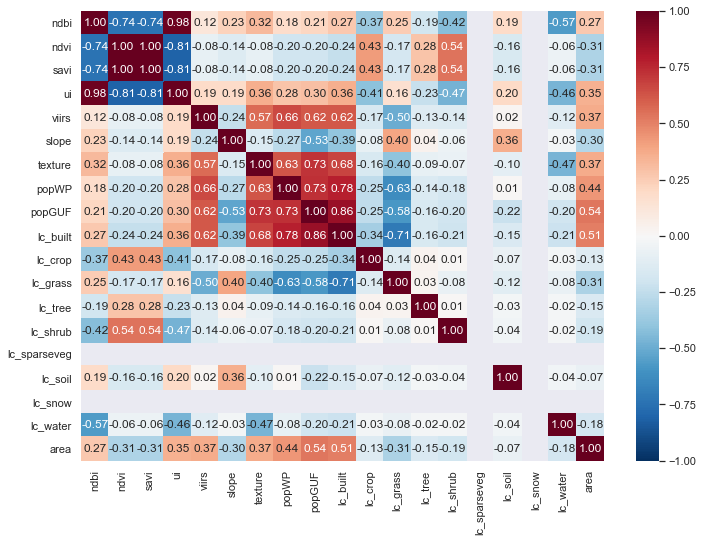

In [148]:
# this is the AFLC with 11 classes

#plot correlation matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(trainingGeoDF.corr(), annot=True, fmt=".2f",cmap='RdBu_r', center=0, vmin=-1, vmax=1)

In [149]:
trainingFeatureDF = trainingGeoDF[['ndbi','ndvi','savi','ui','viirs','slope','texture','popWP','popGUF','lc_built','lc_crop','lc_grass','lc_tree', 'lc_shrub','lc_sparseveg', 'lc_soil','lc_snow','lc_water']]
trainingTargetDF = trainingGeoDF['area'] # area is the m^2 of the training sample

In [150]:
X_train, X_test, y_train, y_test = train_test_split(trainingFeatureDF, trainingTargetDF, test_size=0.4, random_state=42)

### run random forest regression with default settings

#### fit is actually lower than it was with the 1km GLC. (r2 = .697)

0.6867860520488535
4672.015763607591


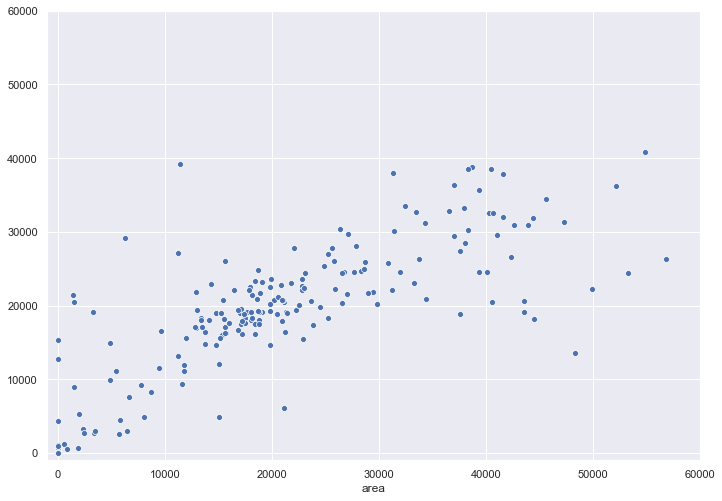

In [151]:
# this is the AFLC with 11 classes

#fit with default settings for reference (70/30 training/test split, no cross validation)
RandomForest = RandomForestRegressor()
RandomForest.fit(X_train, y_train)
y_pred = RandomForest.predict(X_test)
print(r2_score(y_test,y_pred))
ax1 = sns.scatterplot(x=y_test,y=y_pred)
ax1.set(ylim=(-1000, 60000))
ax1.set(xlim=(-1000, 60000))
print(mean_absolute_error(y_test,y_pred))

In [152]:
#fit with optimized settings (takes a few minutes)

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}
0.6717693539572558
5238.39375507098


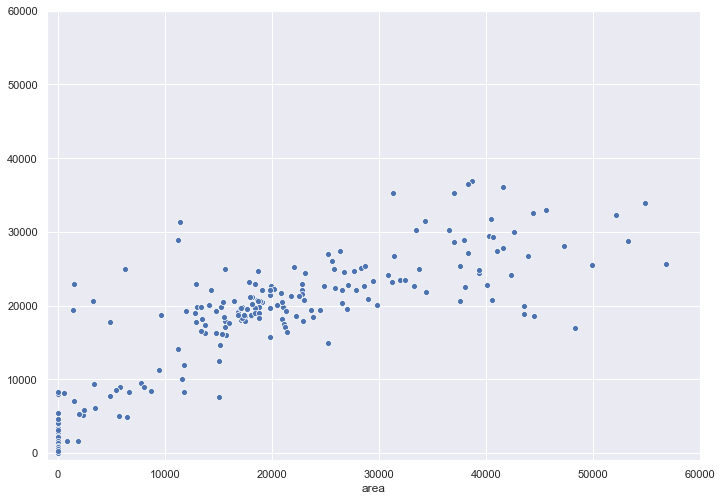

In [153]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_
y_pred = best_random.predict(X_test)
print(r2_score(y_test,y_pred))
ax = sns.scatterplot(x=y_test,y=y_pred)
ax.set(ylim=(-1000, 60000))
ax.set(xlim=(-1000, 60000))
print(mean_absolute_error(y_test,y_pred))

In [154]:
import joblib
#define location to save model
filename = r"P:\AFG\GEO\Team\Projects\OSM_Completeness\20200910_AFLC\trainedAfg575_AFLC_multiclass_all.sav"
joblib.dump(best_random, filename)

['P:\\AFG\\GEO\\Team\\Projects\\OSM_Completeness\\20200910_AFLC\\trainedAfg575_AFLC_multiclass_all.sav']

C:\ProgramData\Anaconda3\envs\gostnets0220\osm_completeness\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


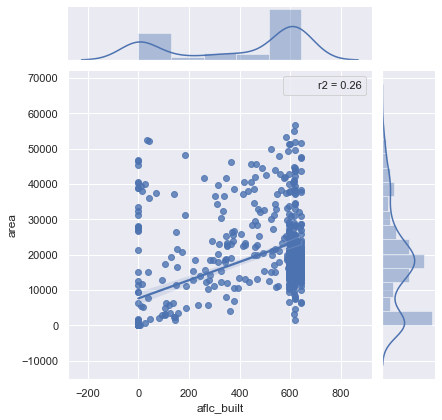

In [107]:
from scipy import stats
def r2(x,y):
    return stats.pearsonr(x,y)[0] a** 2
sns.jointplot(x="aflc_built", y="area", data=trainingDF, kind="reg", stat_func=r2)

# r2 for built area = 0.26